In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time as t

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 1152),
            nn.BatchNorm1d(1152),
            nn.LeakyReLU()
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(1152, 128, kernel_size=3, stride=1, padding=0),  # 1x1 → 3x3
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),  # 3x3 → 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 → 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )

        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # 14,14 → 28,28
            nn.Tanh()  # Output range [-1,1]
        )

    def forward(self, z):
        # print("start")
        # print(z.shape)
        z = self.layer1(z)
        z = z.view(-1, 1152, 1, 1)
        # print(z.shape)
        z = self.layer2(z)
        # print(z.shape)
        z = self.layer3(z)
        # print(z.shape)
        z = self.layer4(z)
        # print(z.shape)
        z = self.layer5(z)
        # print(z.shape)
        return z

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 → 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 → 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7 → 3x3
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 1152, kernel_size=3, stride=1, padding=0),  # 3x3 → 1x1
            nn.BatchNorm2d(1152),
            nn.LeakyReLU()
        )

        self.output_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1152, latent_dim),  # Map to latent dimension (Purple "n" block)
            nn.LeakyReLU(),
            nn.Linear(latent_dim, 1),  # Final output layer
            nn.Sigmoid()  # Probability output [0,1]
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        # print(x.shape)
        x = self.layer1(x)  # Process through convolutional layers (Orange)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.layer3(x)
        # print(x.shape)
        x = self.layer4(x)
        # print(x.shape)
        x = self.output_layers(x)  # Process through fully connected layers (Purple)
        # print(x.shape)
        return x


In [3]:
# Hyperparameters
latent_dim = 100
epochs = 20
batch_size = 64
lr = 0.001

In [13]:
# Initialize models
generator = Generator(latent_dim)
discriminator = Discriminator(latent_dim)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# Loss function
criterion = nn.BCELoss()

In [14]:
# Data loader (MNIST dataset)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print("Training")

start_time = t.time()

for epoch in range(epochs):
    current_time = t.time()
    print(f"Time: {current_time - start_time}")
    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.shape[0]
        real_imgs = real_imgs.view(batch_size, -1)

        # Labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), real_labels)

        z = torch.randn(batch_size, latent_dim)  # Random noise
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), real_labels)  # Fool the discriminator
        g_loss.backward()
        optimizer_G.step()

    print(epoch)
    print(f"Epoch {epoch}: D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
    
    # Show sample images
    with torch.no_grad():
        z = torch.randn(16, latent_dim)
        samples = generator(z).view(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(samples, normalize=True)
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.show()

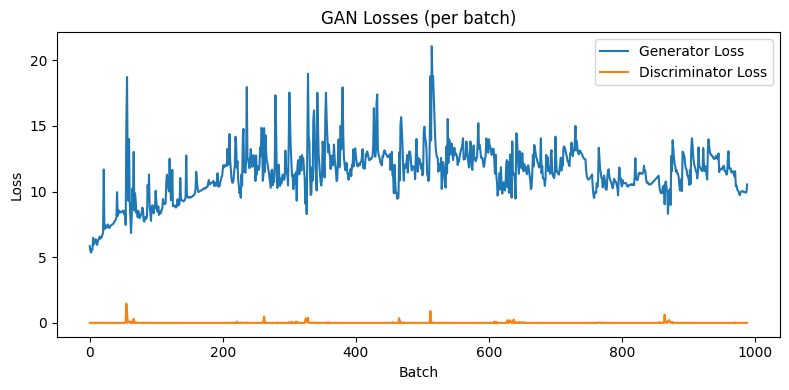

Epoch 2/20:   8%|▊         | 73/938 [00:11<02:13,  6.46it/s]


KeyboardInterrupt: 

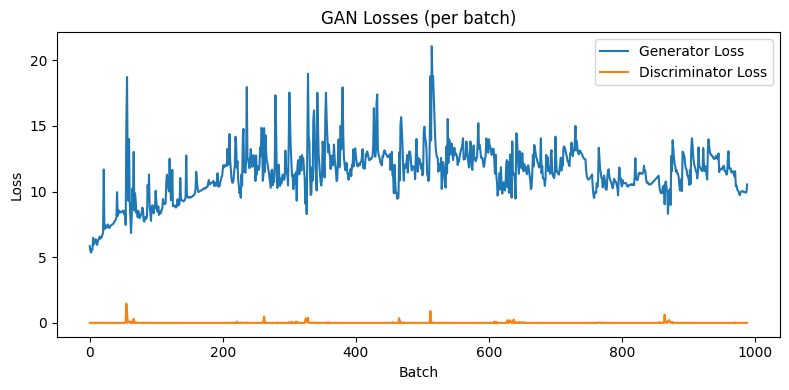

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import os

G_losses = []
D_losses = []

# Directory to save generated images
os.makedirs("gan_samples", exist_ok=True)

# Start the first GAN loss plot
plt.ion()
fig, ax = plt.subplots(figsize=(8, 4))

print("Training")
start_time = t.time()

for epoch in range(epochs):
    current_time = t.time()
    print(f"Time: {current_time - start_time}")

    for i, (real_imgs, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        batch_size = real_imgs.shape[0]
        real_imgs = real_imgs.view(batch_size, -1)

        # Labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_outputs = discriminator(real_imgs)
        real_loss = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_dim)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Store losses for every batch
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Live plot update every 50 batches
        if i % 50 == 0:
            ax.clear()
            ax.plot(G_losses, label='Generator Loss')
            ax.plot(D_losses, label='Discriminator Loss')
            ax.set_title('GAN Losses (per batch)')
            ax.set_xlabel('Batch')
            ax.set_ylabel('Loss')
            ax.legend()
            plt.tight_layout()
            display.clear_output(wait=True)
            display.display(fig)

    # End and show the GAN loss plot for this epoch
    plt.ioff()
    plt.show()

    # Save generated images to disk (not shown interactively)
    with torch.no_grad():
        z = torch.randn(16, latent_dim)
        samples = generator(z).view(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(samples, normalize=True)
        fig_img, ax_img = plt.subplots(figsize=(4, 4))
        ax_img.imshow(grid.permute(1, 2, 0).numpy())
        ax_img.axis('off')
        ax_img.set_title(f"Generated Samples at Epoch {epoch+1}")
        plt.savefig(f"gan_samples/generated_epoch_{epoch+1}_at Time_{current_time}.png")
        plt.close(fig_img)

    # Start a new GAN loss plot for the next epoch
    plt.ion()
    fig, ax = plt.subplots(figsize=(8, 4))

plt.ioff()
plt.show()